<a href="https://www.kaggle.com/code/wlnfdhln/klasifikasi-gambar?scriptVersionId=299189334" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Proyek Klasifikasi Gambar: WildlifeReID-10k
- **Nama:** wildan fadhil nazaruddin
- **Email:** wildanfadhil76@gmail.com
- **ID Dicoding:** @WildanFadhilNazaruddin

## Import Semua Packages/Library yang Digunakan

In [7]:
import pandas as pd
from pathlib import Path
import kagglehub
import shutil
from collections import defaultdict
import zipfile
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from skimage import io
import cv2
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage import img_as_ubyte
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from PIL import Image
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import os
import shutil
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




2026-02-21 21:30:14.039229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771709414.060337      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771709414.067177      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771709414.083920      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771709414.083941      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771709414.083944      55 computation_placer.cc:177] computation placer alr

## Data Preparation

### load images dataset

In [8]:
# set path dataset Kaggle (tanpa download ulang)
KAGGLE_INPUT_ROOT = Path("/kaggle/input/datasets/wildlifedatasets/wildlifereid-10k")
print(f"KAGGLE_INPUT_ROOT: {KAGGLE_INPUT_ROOT}")
print("Tersedia:", KAGGLE_INPUT_ROOT.exists())

KAGGLE_INPUT_ROOT: /kaggle/input/datasets/wildlifedatasets/wildlifereid-10k
Tersedia: True


In [9]:
# membuat folder 
# set path sumber dan target (zebra, leopard, tiger)

if KAGGLE_INPUT_ROOT.exists():
    TARGET_ROOT = Path("/kaggle/working/data")
else:
    TARGET_ROOT = Path(r"D:\Projeck\sentimen analisis gambar\submission\data")

TARGET_ROOT.mkdir(parents=True, exist_ok=True)

SOURCE_DIRS = {
    "tiger": KAGGLE_INPUT_ROOT / "images" / "ATRW",
    "zebra": KAGGLE_INPUT_ROOT / "images" / "GiraffeZebraID",
    "leopard": KAGGLE_INPUT_ROOT / "images" / "LeopardID2022",
}

TARGET_DIRS = {
    "zebra": TARGET_ROOT / "zebra",
    "leopard": TARGET_ROOT / "leopard",
    "tiger": TARGET_ROOT / "tiger",
}

MAX_PER_CLASS = 5000
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff"}

# validasi sumber
selected_sources = {
    label: (path if path.exists() and path.is_dir() else None)
    for label, path in SOURCE_DIRS.items()
}

print("Sumber yang terdeteksi:")
for label in ["zebra", "leopard", "tiger"]:
    print(f"- {label}: {selected_sources[label]}")

print("\nTarget folder:")
for label in ["zebra", "leopard", "tiger"]:
    print(f"- {label}: {TARGET_DIRS[label]}")

print(f"\nBatas per kelas: {MAX_PER_CLASS} gambar")
print(f"Root output data: {TARGET_ROOT}")

Sumber yang terdeteksi:
- zebra: /kaggle/input/datasets/wildlifedatasets/wildlifereid-10k/images/GiraffeZebraID
- leopard: /kaggle/input/datasets/wildlifedatasets/wildlifereid-10k/images/LeopardID2022
- tiger: /kaggle/input/datasets/wildlifedatasets/wildlifereid-10k/images/ATRW

Target folder:
- zebra: /kaggle/working/data/zebra
- leopard: /kaggle/working/data/leopard
- tiger: /kaggle/working/data/tiger

Batas per kelas: 5000 gambar
Root output data: /kaggle/working/data


In [10]:
# menyalin semua gambar ke folder data per kelas (maksimal 5000 per kelas)
for target in TARGET_DIRS.values():
    target.mkdir(parents=True, exist_ok=True)

def iter_images(folder: Path):
    for p in folder.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMAGE_EXTS:
            yield p

def count_images(folder: Path):
    return sum(1 for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in IMAGE_EXTS)

def unique_target_path(dst_dir: Path, src_path: Path, prefix: str):
    base_name = src_path.stem.replace(" ", "_")
    ext = src_path.suffix.lower()
    candidate = dst_dir / f"{prefix}_{base_name}{ext}"
    counter = 1
    while candidate.exists():
        candidate = dst_dir / f"{prefix}_{base_name}_{counter}{ext}"
        counter += 1
    return candidate

copy_stats = {"zebra": 0, "leopard": 0, "tiger": 0}
missing_sources = []

for label, src_root in selected_sources.items():
    dst_root = TARGET_DIRS[label]

    if src_root is None:
        missing_sources.append(label)
        continue

    current_target_count = count_images(dst_root)
    move_quota = max(0, MAX_PER_CLASS - current_target_count)

    print(f"Proses {label}: {src_root} -> {dst_root}")
    print(f"  target saat ini: {current_target_count}, kuota pindah: {move_quota}")

    if move_quota == 0:
        print("  lewati: target sudah mencapai/melebihi batas")
        continue

    moved = 0
    for src_img in iter_images(src_root):
        if moved >= move_quota:
            break

        # lewati jika file sudah berada di folder target
        if src_img.parent.resolve() == dst_root.resolve():
            continue

        dst_img = unique_target_path(dst_root, src_img, label.lower())
        shutil.copy2(str(src_img), str(dst_img))
        moved += 1

    copy_stats[label] = moved
    print(f"  selesai: {moved} file disalin")

print("\nRingkasan penyalinan:")
for label in ["zebra", "leopard", "tiger"]:
    total_now = count_images(TARGET_DIRS[label])
    print(f"- {label}: +{copy_stats[label]} file, total sekarang {total_now}")

if missing_sources:
    print("\nSumber tidak ditemukan:", ", ".join(missing_sources))

Proses tiger: /kaggle/input/datasets/wildlifedatasets/wildlifereid-10k/images/ATRW -> /kaggle/working/data/tiger
  target saat ini: 0, kuota pindah: 5000
  selesai: 5000 file disalin
Proses zebra: /kaggle/input/datasets/wildlifedatasets/wildlifereid-10k/images/GiraffeZebraID -> /kaggle/working/data/zebra
  target saat ini: 0, kuota pindah: 5000
  selesai: 5000 file disalin
Proses leopard: /kaggle/input/datasets/wildlifedatasets/wildlifereid-10k/images/LeopardID2022 -> /kaggle/working/data/leopard
  target saat ini: 0, kuota pindah: 5000
  selesai: 5000 file disalin

Ringkasan penyalinan:
- zebra: +5000 file, total sekarang 5000
- leopard: +5000 file, total sekarang 5000
- tiger: +5000 file, total sekarang 5000


In [11]:

SEED = 42
IMG_SIZE = (224, 224)  # ukuran resize output
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15
CLEAN_OUTPUT = True

assert abs((TRAIN_RATIO + VAL_RATIO + TEST_RATIO) - 1.0) < 1e-9, "Total rasio harus 1.0"

CLASS_NAMES = ["zebra", "leopard", "tiger"]
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff", ".gif"}

# Source data (hasil copy sebelumnya ada di /kaggle/working/data)
CANDIDATE_BASES = [
    Path("/kaggle/working/"),
    Path(r"D:\Projeck\sentimen analisis gambar\submission"),
    Path("/content/submission"),
]

BASE = next((p for p in CANDIDATE_BASES if p.exists()), None)
if BASE is None:
    raise FileNotFoundError("Base folder tidak ditemukan. Atur variabel BASE secara manual.")

def detect_source_root(base: Path, class_names):
    candidates = [
        base / "data",
        base,
        base / "dataset",
    ]
    for candidate in candidates:
        if candidate.exists() and all((candidate / cls).exists() for cls in class_names):
            return candidate
    return None

SOURCE_ROOT = detect_source_root(BASE, CLASS_NAMES)
if SOURCE_ROOT is None:
    raise FileNotFoundError(
        f"Folder sumber kelas tidak ditemukan dari BASE={BASE}. "
        "Pastikan ada folder zebra/leopard/tiger di bawah BASE/data atau BASE."
    )

# Output split
OUT_ROOT = BASE / "split_dataset"
OUT_TRAIN = OUT_ROOT / "train"
OUT_VAL = OUT_ROOT / "val"
OUT_TEST = OUT_ROOT / "test"

random.seed(SEED)

def list_images(folder: Path):
    return [p for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in IMAGE_EXTS]

def reset_output_dirs():
    if CLEAN_OUTPUT and OUT_ROOT.exists():
        shutil.rmtree(OUT_ROOT)
    for split_dir in [OUT_TRAIN, OUT_VAL, OUT_TEST]:
        split_dir.mkdir(parents=True, exist_ok=True)

def unique_output_path(dst_dir: Path, filename: str):
    dst = dst_dir / filename
    if not dst.exists():
        return dst
    stem = Path(filename).stem
    suffix = Path(filename).suffix
    counter = 1
    while True:
        candidate = dst_dir / f"{stem}_{counter}{suffix}"
        if not candidate.exists():
            return candidate
        counter += 1

def resize_and_save(src_path: Path, dst_path: Path):
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    with Image.open(src_path) as img:
        width, height = img.size  # simpan ukuran asli untuk metadata
        img = img.convert("RGB")
        img = img.resize(IMG_SIZE, Image.Resampling.LANCZOS)
        dst_path = dst_path.with_suffix(".jpg")
        img.save(dst_path, format="JPEG", quality=95)
    return dst_path, width, height

def split_counts(n, train_ratio, val_ratio):
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val
    return n_train, n_val, n_test

print(f"BASE aktif: {BASE}")
print(f"SOURCE_ROOT: {SOURCE_ROOT}")
print(f"OUTPUT ROOT: {OUT_ROOT}")

reset_output_dirs()
records = []

for class_name in CLASS_NAMES:
    src_dir = SOURCE_ROOT / class_name
    if not src_dir.exists():
        print(f"[Lewati] Folder kelas tidak ditemukan: {src_dir}")
        continue

    images = list_images(src_dir)
    if len(images) == 0:
        print(f"[Lewati] Tidak ada gambar di: {src_dir}")
        continue

    random.shuffle(images)
    n_train, n_val, n_test = split_counts(len(images), TRAIN_RATIO, VAL_RATIO)

    split_map = [
        ("train", OUT_TRAIN, images[:n_train]),
        ("val", OUT_VAL, images[n_train:n_train + n_val]),
        ("test", OUT_TEST, images[n_train + n_val:]),
    ]

    for split_name, split_root, split_imgs in split_map:
        class_out_dir = split_root / class_name
        class_out_dir.mkdir(parents=True, exist_ok=True)

        for src in split_imgs:
            initial_dst = unique_output_path(class_out_dir, src.name)
            final_dst, width, height = resize_and_save(src, initial_dst)
            records.append({
                "split": split_name,
                "filename": final_dst.name,
                "filepath": str(final_dst),
                "label": class_name,
                "width": width,
                "height": height,
            })

    print(f"{class_name}: total={len(images)} | train={n_train} | val={n_val} | test={n_test}")

# DataFrame sesuai format yang diminta
df = pd.DataFrame(records, columns=["split", "filename", "filepath", "label", "width", "height"])

if df.empty:
    print("\nTidak ada data yang berhasil diproses. Cek SOURCE_ROOT dan isi folder kelas.")
else:
    print("\nSelesai split + copy + resize + label.")
    print(df["split"].value_counts())
    print(df["label"].value_counts())

df.head()

BASE aktif: /kaggle/working
SOURCE_ROOT: /kaggle/working/data
OUTPUT ROOT: /kaggle/working/split_dataset
zebra: total=5000 | train=3500 | val=750 | test=750
leopard: total=5000 | train=3500 | val=750 | test=750
tiger: total=5000 | train=3500 | val=750 | test=750

Selesai split + copy + resize + label.
split
train    10500
val       2250
test      2250
Name: count, dtype: int64
label
zebra      5000
leopard    5000
tiger      5000
Name: count, dtype: int64


,split,filename,filepath,label,width,height
0,train,zebra_000000003303_4481.jpg,/kaggle/working/split_dataset/train/zebra/zebr...,zebra,1667,1319
1,train,zebra_000000001262_1828.jpg,/kaggle/working/split_dataset/train/zebra/zebr...,zebra,1375,870
2,train,zebra_000000001438_2130.jpg,/kaggle/working/split_dataset/train/zebra/zebr...,zebra,1658,874
3,train,zebra_000000001996_2840.jpg,/kaggle/working/split_dataset/train/zebra/zebr...,zebra,313,360
4,train,zebra_000000000716_913.jpg,/kaggle/working/split_dataset/train/zebra/zebr...,zebra,782,483


In [12]:
df['label'].value_counts()

label
zebra      5000
leopard    5000
tiger      5000
Name: count, dtype: int64

<Axes: >

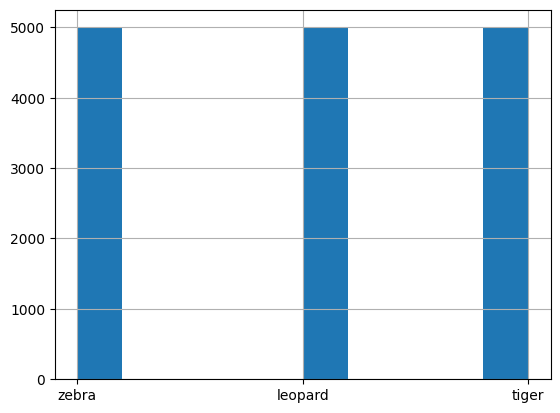

In [13]:
# membuat histogram untuk semua kategori pada class variable
df['label'].hist()

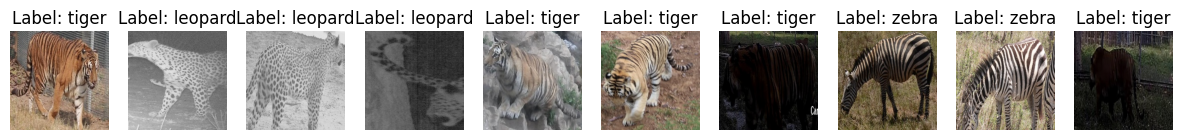

In [14]:
# Pilih hanya 9 gambar pertama (atau pilih subset lainnya jika diperlukan)
df = df.sample(frac=1).reset_index(drop=True).head(10)

# Menampilkan gambar dan label
def display_images_with_labels(df):
    num_images = len(df)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    if num_images == 1:
        axes = [axes]  # Jika hanya satu gambar, axes tidak dalam bentuk list

    for ax, (idx, row) in zip(axes, df.iterrows()):
        img = mpimg.imread(row['filepath'])
        ax.imshow(img)
        ax.set_title(f'Label: {row["label"]}')
        ax.axis('off')  # Menghilangkan axis

    plt.show()

# Panggil fungsi untuk menampilkan gambar
display_images_with_labels(df)

In [15]:
!nvidia-smi
import tensorflow as tf
print("TF:", tf.__version__)
print("CUDA build:", tf.test.is_built_with_cuda())
print("GPU list:", tf.config.list_physical_devices('GPU'))

Sat Feb 21 21:36:51 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Data Spliting

In [16]:
# Callback untuk menghentikan training jika akurasi >95%
class CallbackModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            print("\n\n✅ Target Akurasi Tercapai, Training Berhenti ✅\n")
            self.model.stop_training = True


def hewan():
    TRAIN_DIR = "/kaggle/working/split_dataset/train"
    VAL_DIR = "/kaggle/working/split_dataset/val"
    TEST_DIR = "/kaggle/working/split_dataset/test"

    # Ukuran gambar & batch size
    TARGET_SIZE = (224, 224)  # Disesuaikan dengan model
    BATCH_SIZE = 64

    # Augmentasi training
    training_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        shear_range=0.2,
        rotation_range=30,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        validation_split=0.2  # Bagi 20% untuk validasi
    )

    # Augmentasi Validasi & Test (hanya rescale)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Data Training
    train_generator = training_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        subset='training',  # Ambil 80% data training
        seed=42
    )

    # Data Validasi
    validation_generator = training_datagen.flow_from_directory(
        TRAIN_DIR,  # Harus tetap dari TRAIN_DIR karena pakai validation_split
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        subset='validation',  # Ambil 20% data validasi
        seed=42
    )

    # Data Test
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False  # Jangan diacak agar urutan sesuai
    )

    return train_generator, validation_generator, test_generator

def build_model(train_generator):
    model = tf.keras.models.Sequential([
        #  Convolutional Layer 1
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        MaxPooling2D(2,2),
        BatchNormalization(),

        #  Convolutional Layer 2
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        BatchNormalization(),
        Dropout(0.2),

        #  Convolutional Layer 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        BatchNormalization(),
        Dropout(0.2),

        #  Convolutional Layer 4
        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        BatchNormalization(),
        Dropout(0.2),

        #  Convolutional Layer 5
        Conv2D(512, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        BatchNormalization(),
        Dropout(0.2),

        #  Fully Connected Layer
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),

        Dense(128, activation='relu'),
        Dropout(0.2),

        Dense(train_generator.num_classes, activation='softmax')  # Output Layer
    ])

    # Optimizer AdamW lebih stabil
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)

    # Kompilasi model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model



#  Training Model
def train_model():
    train_generator, validation_generator, test_generator = hewan()

    # Bangun model
    model = build_model(train_generator)

    # Callback (Stop training jika tidak meningkat)
    callback = [
        CallbackModel(),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
    ]

    # Train model
    history = model.fit(
        train_generator,
        epochs=200,
        steps_per_epoch=len(train_generator),
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=callback,
        verbose=1
    )

    return model, history

In [17]:
model, history = train_model()

Found 8400 images belonging to 3 classes.
Found 2100 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1771709814.137063      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771709814.143137      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can i

Epoch 1/200


I0000 00:00:1771709822.459448     168 service.cc:152] XLA service 0x7d3c7c01a5a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771709822.459487     168 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771709822.459492     168 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771709823.453702     168 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/132 ━━━━━━━━━━━━━━━━━━━━ 48:50 22s/step - accuracy: 0.2656 - loss: 2.3693

I0000 00:00:1771709839.706943     168 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.6760 - loss: 1.9669 - val_accuracy: 0.3324 - val_loss: 2.6521 - learning_rate: 0.0010
Epoch 2/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 128s 969ms/step - accuracy: 0.8731 - loss: 0.4064 - val_accuracy: 0.3338 - val_loss: 4.2059 - learning_rate: 0.0010
Epoch 3/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 127s 965ms/step - accuracy: 0.9227 - loss: 0.2272 - val_accuracy: 0.4548 - val_loss: 1.8755 - learning_rate: 0.0010
Epoch 4/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 129s 974ms/step - accuracy: 0.9400 - loss: 0.1743 - val_accuracy: 0.7533 - val_loss: 1.0297 - learning_rate: 0.0010
Epoch 5/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 128s 969ms/step - accuracy: 0.9474 - loss: 0.1575 - val_accuracy: 0.9110 - val_loss: 0.2575 - learning_rate: 0.0010
Epoch 6/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 127s 962ms/step - accuracy: 0.9548 - loss: 0.1398 - val_accuracy: 0.8995 - val_loss: 0.2698 - learning_rate: 0.0010
Epoch 7/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 128s 969ms/step - accuracy: 0.96

In [18]:
def plot_training_history(history):
    # Ekstrak data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    #  Plot Akurasi
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True)

    #  Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

## Evaluasi dan Visualisasi

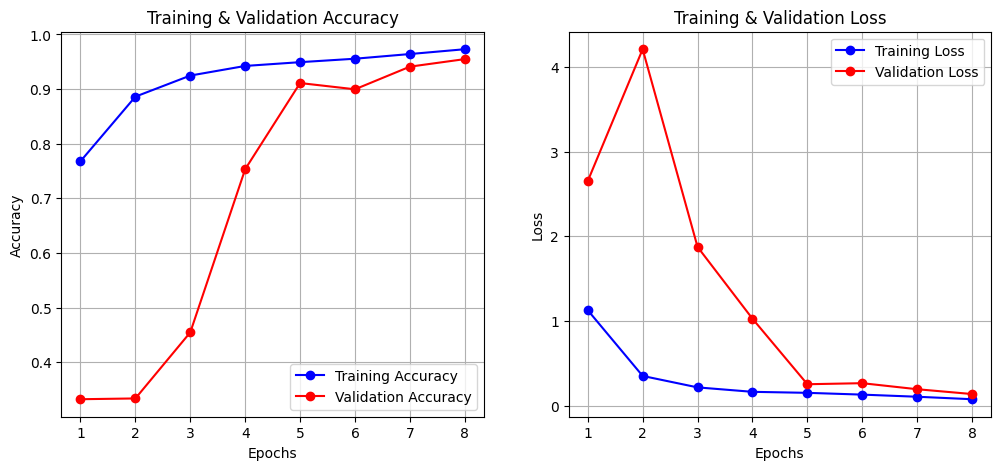

In [19]:
plot_training_history(history)

In [20]:
_, _, test_generator = hewan()  # Panggil kembali untuk mendapatkan test_generator
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n🎯 Akurasi pada Testing Set: {test_acc * 100:.2f}% 🎯")

Found 8400 images belonging to 3 classes.
Found 2100 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9782 - loss: 0.0484

🎯 Akurasi pada Testing Set: 98.67% 🎯


## Konversi Model

### save model

In [27]:
from pathlib import Path
import shutil

# Tentukan base path: Kaggle atau lokal
base_dir = Path("/kaggle/working") if Path("/kaggle/working").exists() else Path.cwd()

# 1) Buat folder model
export_dir = base_dir / "saved_model"
export_dir.mkdir(parents=True, exist_ok=True)

# 2) Export model (SavedModel)
try:
    model.export(str(export_dir))  # Keras 3
except AttributeError:
    model.save(str(export_dir))    # fallback Keras/TensorFlow lama

# 3) Zip agar mudah di-download
zip_path = shutil.make_archive(str(base_dir / "saved_model"), "zip", root_dir=str(export_dir))

print("Model folder:", export_dir)
print("ZIP file:", zip_path)

INFO:tensorflow:Assets written to: /kaggle/working/saved_model/assets


INFO:tensorflow:Assets written to: /kaggle/working/saved_model/assets


Saved artifact at '/kaggle/working/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137702019204112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702129057040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702129057424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702019204304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702129057232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702129056080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702019204880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702019205072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702019203920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702019206224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137

### Tensorflow.js

In [28]:
! pip install tensorflowjs

In [23]:
# Convert the model to TensorFlow.js format
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/model

2026-02-21 21:54:52.437238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771710892.458382     414 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771710892.464712     414 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771710892.480884     414 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771710892.480911     414 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771710892.480916     414 computation_placer.cc:177] computation placer alr

In [24]:
model_dir = Path("/kaggle/working/tfjs_model")
model_dir.mkdir(parents=True, exist_ok=True)

# kalau model belum disimpan:
# model.export(str(model_dir))   # atau model.save(str(model_dir))

zip_path = shutil.make_archive("/kaggle/working/tfjs_model", "zip", root_dir=str(model_dir))
print("ZIP siap:", zip_path)

ZIP siap: /kaggle/working/model.zip


### Tensoflow lite

In [25]:
# 1) Convert SavedModel -> TFLite
saved_model_dir = "/kaggle/working/tflite"   # sesuaikan dengan folder export Anda
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# 2) Simpan file .tflite
tflite_path = "/kaggle/working/model.tflite"
with tf.io.gfile.GFile(tflite_path, "wb") as f:
    f.write(tflite_model)

# 3) Simpan label
# sesuaikan urutan label dengan training Anda
class_labels = ["zebra", "leopard", "tiger"]   # ganti jika memang kelas Anda beda

label_path = "/kaggle/working/label.txt"
with open(label_path, "w") as f:
    for label in class_labels:
        f.write(f"{label}\n")

print("TFLite saved:", tflite_path)

W0000 00:00:1771710900.771482      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1771710900.771521      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1771710900.793385      55 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


TFLite saved: /kaggle/working/model.tflite


In [26]:
!pip install pipreqs
!pipreqs /kaggle/working --force --savepath /kaggle/working/requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 15.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.0 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=502d461f1c72e838d6d81bafd80fe690b0f2f113b2d1d6d962172cc0c1ce0aba
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.4.5
    Uninstalling nbconver